In [1]:
import os
import time
import pandas as pd
import numpy as np
import datashader as ds
import datashader.transfer_functions as tf
from sklearn.cluster import KMeans, DBSCAN
import multiprocessing

In [2]:
# Load from HDF5 file

project = os.path.realpath('./..')
datadir = os.path.join(project, 'data')

with pd.HDFStore(os.path.join(datadir, 'tweets_1M.h5')) as store:
    subset = store.tweets_subset

In [3]:
subset

,id,lat,lng,text,timeStamp,user_id
548401,382659014066069504,38.475038,-122.814960,@PairingsEd seriously! Just started too #foodi...,2013-09-25 00:13:13,48737246
411317,381561498083930112,37.360357,-122.004599,@andweealol AYYYY WE OUT HERE,2013-09-21 23:32:04,594059393
775335,384486127261851648,37.869231,-122.290983,#Ponuzo by the bro @HandleOfLife drops soon. G...,2013-09-30 01:13:30,235498242
788161,384543835205824513,37.564399,-122.294308,@alaany2 like I'd adopt you but that's weird b...,2013-09-30 05:02:49,142078918
306738,380711938272935937,37.735391,-122.437684,@jrostar @MattBeNimble You guys evaluated Citr...,2013-09-19 15:16:14,76858863
698773,383844386301173760,36.922310,-121.760358,Fuck! I have class tomorow at 8 fml why did it...,2013-09-28 06:43:27,82532461
966696,386020563795189760,37.675343,-122.144309,My kitty is so scared of the wind 😟,2013-10-04 06:50:48,1852962362
799904,384698434382344192,38.304040,-121.318307,Last day being alone!,2013-09-30 15:17:08,560958996
976140,386179037594284032,37.284876,-121.859165,"I'm that girl who tells her hairstylist ""I wan...",2013-10-04 17:20:32,103992417
208799,379833883425923072,37.934976,-121.736011,@JacquelineKekos I really miss you rn,2013-09-17 05:07:09,506102353


In [4]:
# Convert the lat and lng columns to numpy array
data = subset.as_matrix(columns=['lat', 'lng'])

In [6]:
data

array([[  38.47503753, -122.81495956],
       [  37.36035664, -122.00459909],
       [  37.86923141, -122.29098302],
       ..., 
       [  37.59345666, -122.41503457],
       [  37.72395007, -122.48249918],
       [  38.34084666, -122.67606236]])

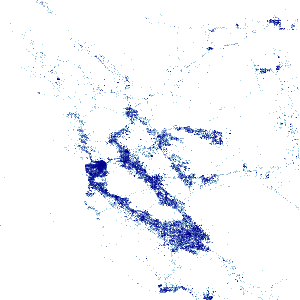

In [5]:
# Visualize points with datashader

cvs = ds.Canvas(plot_width=300, plot_height=300)
agg = cvs.points(subset, 'lng', 'lat')
tf.interpolate(agg)

In [6]:
# Prepare the k-means model object

k_means = KMeans(n_clusters=3,
                 init='k-means++',
                 n_init=10)

In [7]:
# Start timer
t0 = time.time()

# Fit the data and save timing
k_means.fit(data)
k_means_time = time.time() - t0
print k_means_time

# Add fitted label back into DataFrame
subset['cluster'] = k_means.labels_

0.526290178299


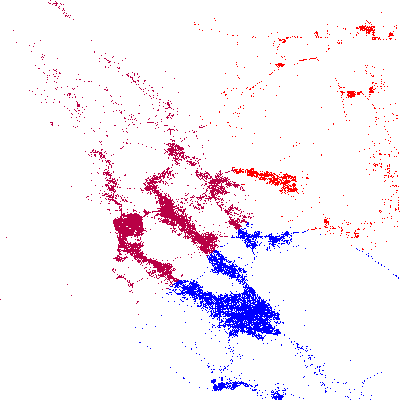

In [8]:
# Visualize points with datashader
cvs = ds.Canvas(plot_width=400, plot_height=400)
agg = cvs.points(subset, 'lng', 'lat', ds.mean('cluster'))
tf.interpolate(agg, cmap=['red', 'blue'])